# Relax Take-Home Challenge

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven day period , <b> identify which factors predict future user adoption</b>.

In [1]:
#import modules and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import itertools

In [2]:
#load dataset

df=pd.read_csv('takehome_user_engagement.csv')
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
df.shape

(207917, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
#convert time stamp into datetime format
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [6]:
df['date'] = df['time_stamp'].dt.date

In [7]:
df = df.drop(columns=['time_stamp'])

In [8]:
df.head()

,user_id,visited,date
0,1,1,2014-04-22
1,2,1,2013-11-15
2,2,1,2013-11-29
3,2,1,2013-12-09
4,2,1,2013-12-25


In [9]:
#get amount of time user_id logged in

df['login_total'] = df.groupby('user_id')['visited'].transform('sum')
df.head()

,user_id,visited,date,login_total
0,1,1,2014-04-22,1
1,2,1,2013-11-15,14
2,2,1,2013-11-29,14
3,2,1,2013-12-09,14
4,2,1,2013-12-25,14


In [10]:
#users are filterd with 3 or more logins
active_users = df[df['login_total'] >= 3]
active_users.head()

,user_id,visited,date,login_total
1,2,1,2013-11-15,14
2,2,1,2013-11-29,14
3,2,1,2013-12-09,14
4,2,1,2013-12-25,14
5,2,1,2013-12-31,14


In [11]:
active_users['user_id'].nunique()

2248

In [12]:
active_users = active_users.drop(columns=['visited', 'login_total'])
active_users

,user_id,date
1,2,2013-11-15
2,2,2013-11-29
3,2,2013-12-09
4,2,2013-12-25
5,2,2013-12-31
...,...,...
207905,11991,2014-04-20
207906,11991,2014-04-25
207907,11991,2014-04-28
207908,11991,2014-05-17


In [13]:
active_users['date'] = pd.to_datetime(active_users['date'])

In [14]:
# retention date is made 7 days after a user logins
active_users['retention_date'] = active_users['date'].apply(lambda x:x + relativedelta(days=+7))

In [15]:
active_users = active_users.reset_index(inplace=False)

In [16]:
active_users.head(20)

,index,user_id,date,retention_date
0,1,2,2013-11-15,2013-11-22
1,2,2,2013-11-29,2013-12-06
2,3,2,2013-12-09,2013-12-16
3,4,2,2013-12-25,2014-01-01
4,5,2,2013-12-31,2014-01-07
5,6,2,2014-01-08,2014-01-15
6,7,2,2014-02-03,2014-02-10
7,8,2,2014-02-08,2014-02-15
8,9,2,2014-02-09,2014-02-16
9,10,2,2014-02-13,2014-02-20


Adopted user is found using the retention date and the date after 2 logins were used to compare if the user logged in 3 times in a 7 day span.


In [17]:
adopted_user = []
for i in range(len(active_users) - 2):
    user = active_users['user_id'][i]
    if active_users['date'][i + 2]  <= active_users['retention_date'][i]:
        user = 1
    else: 
        user = 0
    adopted_user.append(user)

Last 2 user log-ins were added as 0 due to no date to compare to. This will also even out the index numbers of the list to the dataset.

In [18]:
adopted_user.append(0)
adopted_user.append(0)

In [19]:
len(adopted_user)

201002

In [20]:
active_users['adopted_user'] = adopted_user

In [21]:
active_users.head(20)

,index,user_id,date,retention_date,adopted_user
0,1,2,2013-11-15,2013-11-22,0
1,2,2,2013-11-29,2013-12-06,0
2,3,2,2013-12-09,2013-12-16,0
3,4,2,2013-12-25,2014-01-01,0
4,5,2,2013-12-31,2014-01-07,0
5,6,2,2014-01-08,2014-01-15,0
6,7,2,2014-02-03,2014-02-10,1
7,8,2,2014-02-08,2014-02-15,1
8,9,2,2014-02-09,2014-02-16,1
9,10,2,2014-02-13,2014-02-20,0


In [22]:
active_users = active_users.drop(columns=['index'])

In [23]:
active_users

,user_id,date,retention_date,adopted_user
0,2,2013-11-15,2013-11-22,0
1,2,2013-11-29,2013-12-06,0
2,2,2013-12-09,2013-12-16,0
3,2,2013-12-25,2014-01-01,0
4,2,2013-12-31,2014-01-07,0
...,...,...,...,...
200997,11991,2014-04-20,2014-04-27,0
200998,11991,2014-04-25,2014-05-02,0
200999,11991,2014-04-28,2014-05-05,0
201000,11991,2014-05-17,2014-05-24,0


In [24]:
#adopted users are identified
active = active_users[active_users['adopted_user'] == 1]


In [25]:
active = active['user_id'].unique()

In [26]:
active

array([    2,    10,    20, ..., 11975, 11980, 11988], dtype=int64)

In [27]:
len(active)

2027

There are 2027 adopted users

In [28]:
active = pd.DataFrame(active, columns=['user_id'])

In [29]:
active

,user_id
0,2
1,10
2,20
3,33
4,42
...,...
2022,11967
2023,11969
2024,11975
2025,11980


In [30]:
df2 = pd.read_csv('takehome_users.csv',  encoding='latin-1')

In [31]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [32]:
#merge adopted used that were identified

test_data = df2.assign(result=df2['object_id'].isin(active['user_id']).astype(int))

In [33]:
test_data

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,result
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


In [34]:
test_data.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
result                          int32
dtype: object

In [35]:
test_data.shape

(12000, 11)

In [37]:
#drop missing data

missing_new = pd.concat([test_data.isnull().sum(), 100 * test_data.isnull().mean()], axis=1)
missing_new.columns = ['count', '%']
missing_new.sort_values(by='count')

,count,%
object_id,0,0.000
creation_time,0,0.000
name,0,0.000
email,0,0.000
creation_source,0,0.000
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000
result,0,0.000
last_session_creation_time,3177,26.475


In [38]:
test_data = test_data.dropna()

In [39]:
test_data.shape

(4776, 11)

In [40]:
test_result = test_data['result']

In [41]:
test_data = test_data.drop(columns =['result', 'object_id', 'name', 'email', 'creation_time' ])
test_data.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [42]:
#turn categorical data into numerical data
dummy = ['creation_source']
dummies = test_data[dummy]
dummies = pd.get_dummies(dummies)

In [43]:
test_data = pd.concat([test_data, dummies], axis=1)
test_data = test_data.drop(columns=['creation_source'])

In [44]:
test_data.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE
0,1.398139e+09,1,0,11,10803.0,1,0
1,1.396238e+09,0,0,1,316.0,0,1
2,1.363735e+09,0,0,94,1525.0,0,1
3,1.369210e+09,0,0,1,5151.0,1,0
4,1.358850e+09,0,0,193,5240.0,1,0


In [45]:
#scale data
scaler = StandardScaler()
scaled = scaler.fit_transform(test_data)
scaled = pd.DataFrame(scaled)

In [46]:
scaled.head()

,0,1,2,3,4,5,6
0,0.959821,1.709147,-0.425108,-1.056372,1.420951,1.416883,-1.416883
1,0.862602,-0.585087,-0.425108,-1.137809,-1.669044,-0.705775,0.705775
2,-0.799350,-0.585087,-0.425108,-0.380448,-1.312812,-0.705775,0.705775
3,-0.519383,-0.585087,-0.425108,-1.137809,-0.244411,1.416883,-1.416883
4,-1.049146,-0.585087,-0.425108,0.425774,-0.218187,1.416883,-1.416883


In [47]:
#train-test split
x = scaled
y = test_result

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Random Forest Model

In [48]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print('Train Score:', rf.score(x_train, y_train))
print('Test Score:', rf.score(x_test, y_test))

Train Score: 0.999738219895288
Test Score: 0.8326359832635983


In [49]:
y_pred_rf = rf.predict(x_test)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

[[657  35]
 [125 139]]


In [50]:
cv_scores_train_rf = cross_val_score(rf, x_train, y_train, cv=3)
cv_scores_test_rf = cross_val_score(rf, x_test, y_test, cv=3)
print(cv_scores_test_rf)

avg_cv_scores_rf_train = cv_scores_train_rf.mean()
avg_cv_scores_rf_test = cv_scores_test_rf.mean()
cv_scores_std_rf = cv_scores_test_rf.std()
classification_report_rf = classification_report(y_test, y_pred_rf)

print('Avg cross validation train score: ', avg_cv_scores_rf_train)
print('Avg cross validation test score: ', avg_cv_scores_rf_test)
print('Standard deviation in cv scores: ', cv_scores_std_rf)
print('Classification Report:' '\n', classification_report_rf)

[0.81818182 0.81818182 0.81761006]
Avg cross validation train score:  0.8552357192801588
Avg cross validation test score:  0.8179912330855728
Standard deviation in cv scores:  0.00026952802789653507
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       692
           1       0.80      0.53      0.63       264

    accuracy                           0.83       956
   macro avg       0.82      0.74      0.76       956
weighted avg       0.83      0.83      0.82       956



## Hyperparameters

In [51]:
rf = RandomForestClassifier()
paramters = {"n_estimators": [100, 200, 300], "max_depth":[2,4,6,8,10]}
rf_cv = GridSearchCV(rf, paramters, cv=5)
rf_cv.fit(x_train, y_train)
rf_cv.best_params_

{'max_depth': 4, 'n_estimators': 100}

In [52]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print("train score:", rf.score(x_train, y_train))
print("test score:", rf.score(x_test, y_test))
print("average validation score:", (cross_validate(rf, x_train, y_train, cv=5)["test_score"]).mean())
print(classification_report(y_test, y_pred_rf))
print((accuracy_score(y_test, y_pred_rf)*100))

train score: 0.8722513089005236
test score: 0.8347280334728033
average validation score: 0.8675392670157068
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       692
           1       0.80      0.53      0.64       264

    accuracy                           0.83       956
   macro avg       0.82      0.74      0.77       956
weighted avg       0.83      0.83      0.82       956

83.47280334728033


## Feature Importance

7


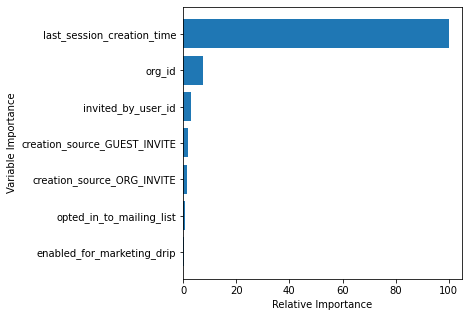

In [54]:
feature_importance = rf.feature_importances_
feature_importance = 100 * (feature_importance / feature_importance.max())[:30]
sorted = np.argsort(feature_importance)[:30]

pos = np.arange(sorted.shape[0]) + .5
print(pos.size)
sorted.size
plt.figure(figsize=(5, 5))
plt.barh(pos, feature_importance[sorted], align='center')
plt.yticks(pos, test_data.columns[sorted])
plt.xlabel('Relative Importance')
plt.ylabel('Variable Importance')
plt.show()

In [55]:
#adopted user percentage
2027 / 12000 * 100

16.891666666666666

## Conclusion

6.9% of the customers are adopted users. I used a random foreset model to classify future user adoption with an accuracy score of 83.69%. The most important feature that determines adopted user is the user's last session creation time.